# EnMAP Uncertainty Analysis

Quantify scene-level retrieval noise by combining the matched-filter concentration map $\Delta X$ and its propagated instrument noise $\sigma_{RMN}$ into clutter-aware diagnostics. The approach assumes Gaussian perturbations and separates detector noise from residual surface/atmospheric structure by analysing plume-free pixels.

**Workflow**
1. Configure the scene metadata plus the concentration/uncertainty rasters and optional plume polygons produced by the pipeline.
2. Rasterise the plume polygons (if provided) so plume pixels can be masked before statistics, ensuring that only background pixels drive the clutter estimate.
3. Build a plume-free, finite mask and compute $\sigma_{tot} = std(\Delta X)$ over those pixels.
4. Aggregate the propagated instrument-noise variance (mean/median) to obtain $\langle\sigma_{RMN}^2\rangle$ and the corresponding representative $\sigma_{RMN}$.
5. Derive $\sigma_{Surf} = \sqrt{\max(0,\sigma_{tot}^2 - \langle\sigma_{RMN}^2\rangle)}$ to capture background clutter.
6. Combine $\sigma_{Surf}$ in quadrature with each plume pixel's $\sigma_{RMN}$ to map the total plume uncertainty and preview the intermediate rasters.
7. Persist the metrics to JSON so downstream reporting or dashboards can ingest the same uncertainty decomposition.


In [10]:
import os
import sys
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

In [11]:
SCENE_OPTIONS = {
    'turkmenistan_plume': {
        'scene_name': 'EnMAP Demo Scene (Turkmenistan plume)',
        'concentration': REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif',
        'uncertainty': REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif',
        'plume_mask': REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap' / 'plumes_mask.shp',
    },
    'agadez_background': {
        'scene_name': 'EnMAP Background Scene (Agadez, methane-free)',
        'concentration': REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap' / 'L1B_DT0000001584_001_20220712T104302Z_20220712T104307Z_MF.tif',
        'uncertainty': REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap' / 'L1B_DT0000001584_001_20220712T104302Z_20220712T104307Z_MF_uncertainty.tif',
        'plume_mask': None,
    },
}

SELECTED_SCENE = 'turkmenistan_plume'  # set to 'agadez_background' to analyse the methane-free scene
SCENE_CONFIG = SCENE_OPTIONS[SELECTED_SCENE]

SCENE_NAME = SCENE_CONFIG['scene_name']
SIGMA_RMN_AGGREGATION = 'mean'  # or 'median'
CONC_PATH = SCENE_CONFIG['concentration']
UNC_PATH = SCENE_CONFIG['uncertainty']
PLUME_MASK_PATH = SCENE_CONFIG['plume_mask']

SUMMARY_DIR = NOTEBOOK_ROOT / 'outputs' / 'uncertainty' / 'enmap'
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)



Using plume mask: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/plumes_mask.shp


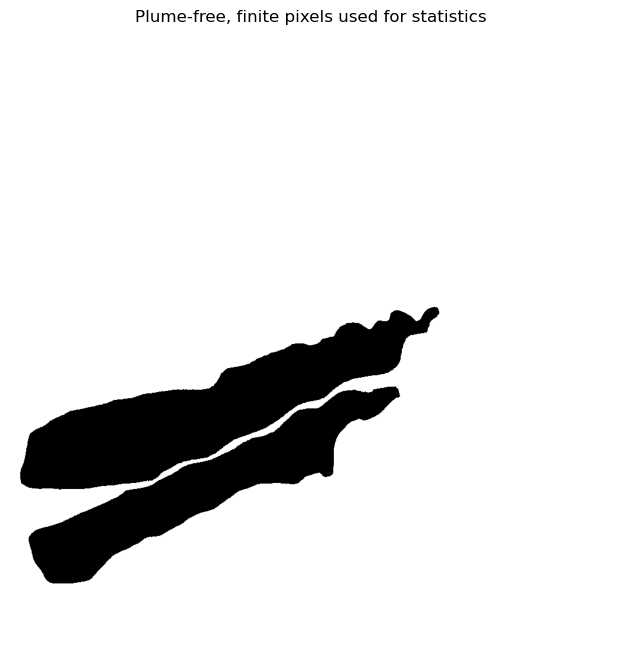

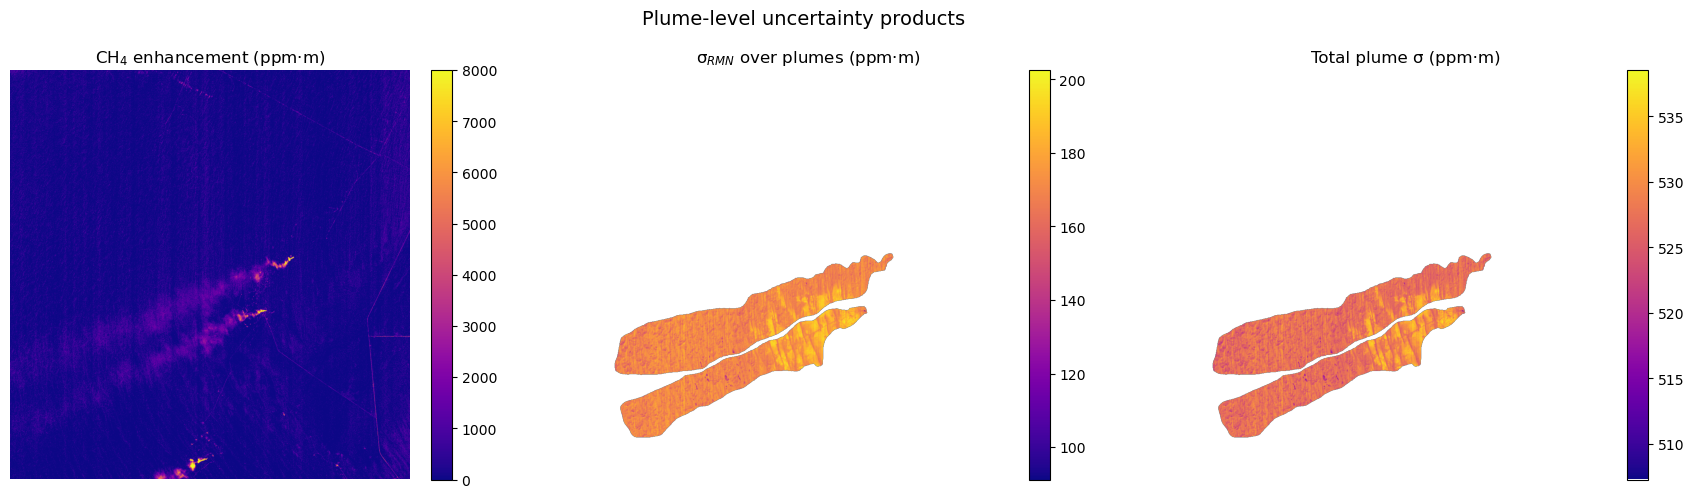

Scene noise metrics:
  scene: EnMAP Demo Scene
  concentration_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif
  uncertainty_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif
  plume_mask_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/plumes_mask.shp
  valid_pixels: 897634
  plume_pixels: 126366
  sigma_tot: 528.0169677734375
  sigma_rmn_sq: 29788.431640625
  sigma_rmn_value: 172.34632873535156
  sigma_surf: 499.0125114824581
  sigma_rmn_aggregation: mean
  mean_plume_sigma_rmn: 171.70561864875938
  mean_plume_sigma_total: 527.7694898109997
Saved metrics to /mnt/d/Lavoro/Assegno_Ricerca_Sapienz

In [12]:
def _read_raster(path: str):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    ds = None
    return arr, geo, proj


def _rasterize_vector(vector_path: str, rows: int, cols: int, geo_transform: tuple, projection: str) -> np.ndarray:
    vector_ds = ogr.Open(vector_path)
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    vector_layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], vector_layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    vector_layer = None
    vector_ds = None
    return mask_array


def _slugify(value: str) -> str:
    return ''.join(ch.lower() if ch.isalnum() else '_' for ch in value).strip('_')


def _mask_array(data: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = np.full(data.shape, np.nan, dtype=float)
    masked[mask] = data[mask]
    return masked


concentration, geo_transform, projection = _read_raster(str(CONC_PATH))
uncertainty, _, _ = _read_raster(str(UNC_PATH))

if concentration.shape != uncertainty.shape:
    raise ValueError('Concentration and uncertainty rasters must share the same shape.')

plume_mask = None
if PLUME_MASK_PATH and PLUME_MASK_PATH.exists():
    print(f'Using plume mask: {PLUME_MASK_PATH}')
    plume_mask = _rasterize_vector(str(PLUME_MASK_PATH), concentration.shape[0], concentration.shape[1], geo_transform, projection)
    plume_free_mask = ~plume_mask
else:
    print('No plume mask provided or found. Calculating statistics over the entire scene.')
    plume_free_mask = np.ones_like(concentration, dtype=bool)

valid_mask = plume_free_mask & np.isfinite(concentration) & np.isfinite(uncertainty)
if not np.any(valid_mask):
    raise ValueError('No valid plume-free pixels available for statistics.')

plt.figure(figsize=(10, 8))
plt.imshow(valid_mask, cmap='gray')
plt.title('Plume-free, finite pixels used for statistics')
plt.axis('off')
plt.show()

delta_x = concentration[valid_mask]
sigma_tot = float(np.nanstd(delta_x, ddof=1))

sigma_rmn_vals = uncertainty[valid_mask]
agg = SIGMA_RMN_AGGREGATION.lower().strip()
if agg == 'median':
    sigma_rmn_stat = float(np.nanmedian(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmedian(sigma_rmn_vals ** 2))
else:
    sigma_rmn_stat = float(np.nanmean(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmean(sigma_rmn_vals ** 2))

sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))

if plume_mask is not None:
    plume_pixels_mask = plume_mask & np.isfinite(concentration) & np.isfinite(uncertainty)
else:
    print('Plume mask missing: plume-level summaries will cover the whole scene.')
    plume_pixels_mask = np.isfinite(concentration) & np.isfinite(uncertainty)

plume_pixel_count = int(plume_pixels_mask.sum())
if plume_pixel_count == 0:
    raise ValueError('No plume pixels available for plume-level uncertainty mapping.')

plume_concentration = _mask_array(concentration, plume_pixels_mask)
plume_sigma_rmn = _mask_array(uncertainty, plume_pixels_mask)
plume_sigma_total = _mask_array(np.sqrt(np.maximum(0.0, uncertainty ** 2 + sigma_surf ** 2)), plume_pixels_mask)

plume_sigma_rmn_mean = float(np.nanmean(plume_sigma_rmn[plume_pixels_mask]))
plume_sigma_total_mean = float(np.nanmean(plume_sigma_total[plume_pixels_mask]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[0].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plume_sigma_rmn, cmap='plasma')
axes[1].set_title('σ$_{RMN}$ over plumes (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plume_sigma_total, cmap='plasma')
axes[2].set_title('Total plume σ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)



for ax in axes:
    ax.axis('off')

plt.suptitle('Plume-level uncertainty products', fontsize=14)
plt.tight_layout()
plt.show()

metrics = {
    'scene': SCENE_NAME,
    'concentration_path': str(CONC_PATH),
    'uncertainty_path': str(UNC_PATH),
    'plume_mask_path': str(PLUME_MASK_PATH) if PLUME_MASK_PATH else None,
    'valid_pixels': int(valid_mask.sum()),
    'plume_pixels': plume_pixel_count,
    'sigma_tot': sigma_tot,
    'sigma_rmn_sq': sigma_rmn_sq,
    'sigma_rmn_value': sigma_rmn_stat,
    'sigma_surf': sigma_surf,
    'sigma_rmn_aggregation': agg,
    'mean_plume_sigma_rmn': plume_sigma_rmn_mean,
    'mean_plume_sigma_total': plume_sigma_total_mean,
}

metrics_path = SUMMARY_DIR / f'{_slugify(SCENE_NAME)}_noise_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Scene noise metrics:')
for key, value in metrics.items():
    print(f'  {key}: {value}')
print(f'Saved metrics to {metrics_path}')



## Result interpretation
The JSON metrics report how much of the plume-free variance is explained by the instrument term versus clutter. Large gaps between $\sigma_{tot}$ and $\sigma_{RMN}$ imply spatial variability (surface texture, residual atmospheric structure) dominates. Inspecting the plume-level maps clarifies where uncertainty is low (bright plumes with small $\sigma_{RMN}$) versus noise-limited edges where $\sigma_{RMN}$ and $\sigma_{Surf}$ are comparable.
